In [13]:
#evaluating based on the model of 3 epochs for DNAse 2/4/23

#now put thorugh model, get logits and calculate ce loss


import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

from src.models.sequence.long_conv_lm import ConvLMHeadModel

# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = ConvLMHeadModel(**config['model_config'])
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load(ckpt_path, map_location=device)

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

epoch = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-03/22-31-47-692332/checkpoints/last.ckpt', max_seq_len=1024)


**Using Char-level tokenizer**


In [4]:
from torch.utils.data import DataLoader
ccre_loader = DataLoader(ccre, batch_size=1, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
# e100loss = torch.zeros((len(ccre), 1023))
# e100acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(epoch.device)
    seq = seq.to(device=epoch.device)
    y_hat = epoch.encode(seq)
    # logits_reshaped = y_hat[0].logits.view(-1, 16)
    # target_reshaped = target.view(-1)
    # print(logits_reshaped.shape)
    # print(target_reshaped.shape)
    
    # losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    # losses = losses.view(b_size, 1023)
    
    # e100loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    # b = torch.argmax(y_hat[0].logits, dim=2)
    # e100acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
    break #just to test and so we don't go the full epoch which will literally take forever!
# print(e100loss[0,:].mean())
# print(e100acc[0,:].mean())


  0%|                                                                                                                                          | 0/126828660 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 0/126828660 [00:00<?, ?it/s]


In [10]:
print(len(y_hat)) #one element
print(y_hat[0].shape) #shape is [1, 1024, 16]

1


AttributeError: 'CausalLMOutput' object has no attribute 'shape'

In [12]:
#it's still causal lm output...
print(y_hat[0].logits.shape) #now is 1 x  1023 x 20... that's definitely the wrong shape!
#wawit the evals was wrong!

torch.Size([1, 1023, 20])


In [19]:
#rerun cell 1 then do this cell

from torch.utils.data import DataLoader
ccre_loader = DataLoader(ccre, batch_size=512, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
# e100loss = torch.zeros((len(ccre), 1023))
# e100acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(epoch.device)
    seq = seq.to(device=epoch.device)
    y_hat = epoch.encode(seq)
    # logits_reshaped = y_hat[0].logits.view(-1, 16)
    # target_reshaped = target.view(-1)
    # print(logits_reshaped.shape)
    # print(target_reshaped.shape)
    
    # losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    # losses = losses.view(b_size, 1023)
    
    # e100loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    # b = torch.argmax(y_hat[0].logits, dim=2)
    # e100acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
    break #just to test and so we don't go the full epoch which will literally take forever!
# print(e100loss[0,:].mean())
# print(e100acc[0,:].mean()) 

  0%|                                                                                                                                             | 0/247713 [00:00<?, ?it/s]

  0%|                                                                                                                                             | 0/247713 [00:10<?, ?it/s]


In [21]:
#print the full vocabulary
print(tokenizer._vocab_str_to_int)

{'[CLS]': 0, '[SEP]': 1, '[BOS]': 2, '[MASK]': 3, '[PAD]': 4, '[RESERVED]': 5, '[UNK]': 6, 'A': 7, 'C': 8, 'G': 9, 'T': 10, 'N': 11, 'S': 12, 'U': 13, 'V': 14, 'W': 15, 'X': 16, 'Y': 17, 'Z': 18}


In [18]:
print(y_hat[0].logits.shape) #shape is [1, 1024, 16]
#wait still it's like this, now it says causal LM output which is the same as before. Maybe we should restart the kernel?



torch.Size([1, 1023, 20])


# try 2 but now that we have the decoder working

In [7]:
#evaluating based on the model of 3 epochs for DNAse 2/4/23

#now put thorugh model, get logits and calculate ce loss


import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        model = DNAEmbeddingModel(**config['model_config']) #this seems to be a key part. also somehow need to load the decoder head
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load(ckpt_path, map_location=device)

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

epoch = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-07/09-47-18-698056/checkpoints/val/mse.ckpt', max_seq_len=1024)
#need to somehow implement it with the decoder head for evaluation, and I am honeslty not sure how... that's a tomorrow problem!

RuntimeError: Error(s) in loading state_dict for DNAEmbeddingModel:
	Unexpected key(s) in state_dict: "decoder.0.output_transform.weight", "decoder.0.output_transform.bias". 

In [2]:
from torch.utils.data import DataLoader
ccre_loader = DataLoader(ccre, batch_size=1, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
# e100loss = torch.zeros((len(ccre), 1023))
# e100acc = torch.zeros((len(ccre), 1023))
startidx = 0
for idx, (seq, target) in tqdm(enumerate(ccre_loader), total=len(ccre_loader)):
    b_size = seq.shape[0]
    target = target.to(epoch.device)
    seq = seq.to(device=epoch.device)
    y_hat = epoch.encode(seq)
    # logits_reshaped = y_hat[0].logits.view(-1, 16)
    # target_reshaped = target.view(-1)
    # print(logits_reshaped.shape)
    # print(target_reshaped.shape)
    
    # losses = F.cross_entropy(logits_reshaped, target_reshaped, reduction='none')
    
    # losses = losses.view(b_size, 1023)
    
    # e100loss[startidx:startidx+b_size,:] = losses.detach().cpu()
    
    # b = torch.argmax(y_hat[0].logits, dim=2)
    # e100acc[startidx:startidx+b_size,:] = (b==target).detach().cpu()
    startidx += b_size
    # full_acc2[idx,:] = (b==target).detach().cpu()
    break #just to test and so we don't go the full epoch which will literally take forever!
# print(e100loss[0,:].mean())
# print(e100acc[0,:].mean())


  0%|                                                                                                                                                                                                    | 0/126828660 [00:00<?, ?it/s]


In [5]:
y_hat[0].logits.shape #why is it still giving me the logits??

torch.Size([1, 1023, 20])

# try 2, combining the models

In [2]:
#evaluating based on the model of 3 epochs for DNAse 2/4/23

#now put thorugh model, get logits and calculate ce loss


import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F


try:
    from tokenizers import Tokenizer  
except:
    pass

#make sure this is correct from the yaml files
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

#define a model that is the combination of the DNAEmbeddingModel and the SequenceDecoder
class CombinedModel(torch.nn.Module):
    def __init__(self, model, decoder):
        super(CombinedModel, self).__init__()
        self.model = model
        self.decoder = decoder
    def forward(self, x):
        x = self.model(x)
        x = self.decoder(x)
        return x
    
#and a pl model
class CombinedModelPL(pl.LightningModule):
    def __init__(self, model, decoder):
        super(CombinedModelPL, self).__init__()
        self.combined_model = CombinedModel(model, decoder)
    def forward(self, x):
        return self.combined_model(x)

class HG38Encoder:
    "Encoder inference for HG38 sequences"
    def __init__(self, model_cfg, ckpt_path, max_seq_len):
        self.max_seq_len = max_seq_len
        self.model, self.tokenizer = self.load_model(model_cfg, ckpt_path)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = self.model.to(self.device)

    def encode(self, seqs):
        # seqs = seqs.to(device=self.device)
        results = []
        # outputs = []

        # sample code to loop thru each sample and tokenize first (char level)
        
        # if isinstance(self.tokenizer, Tokenizer):
        #     tokenized_seq = self.tokenizer.encode(seq, ).ids
        # else:
        #     tokenized_seq = self.tokenizer(seq, padding="max_length")['input_ids']
        # tokenized_seq = tokenized_seq[3:] #make it so the length is 1023 as that's what we expect
        # can accept a batch, shape [B, seq_len, hidden_dim]
        logits = self.model(seqs)[0]

        # Using head, so just have logits
        results.append(logits)
        # outputs.append(output)

        return results
        
            
    def load_model(self, model_cfg, ckpt_path):
        config = yaml.load(open(model_cfg, 'r'), Loader=yaml.FullLoader)
        
        model = DNAEmbeddingModel(**config['model_config']) #this seems to be a key part. also somehow need to load the decoder head
        decoder = SequenceDecoder(128, 1)
        combined_model = CombinedModelPL(model, decoder)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        state_dict = torch.load(ckpt_path, map_location=device)

        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        combined_model.load_state_dict(state_dict["state_dict"])

        # setup tokenizer
        if config['tokenizer_name'] == 'char':
            print("**Using Char-level tokenizer**")

            # add to vocab
            tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=self.max_seq_len + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            # print(tokenizer._vocab_str_to_int)

        return model, tokenizer

epoch = HG38Encoder('/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml', '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-07/09-47-18-698056/checkpoints/val/mse.ckpt', max_seq_len=1024)
#need to somehow implement it with the decoder head for evaluation, and I am honeslty not sure how... that's a tomorrow problem!

RuntimeError: Error(s) in loading state_dict for CombinedModelPL:
	Missing key(s) in state_dict: "combined_model.model.backbone.embeddings.word_embeddings.weight", "combined_model.model.backbone.layers.0.mixer.out_proj.weight", "combined_model.model.backbone.layers.0.mixer.out_proj.bias", "combined_model.model.backbone.layers.0.mixer.in_proj.weight", "combined_model.model.backbone.layers.0.mixer.in_proj.bias", "combined_model.model.backbone.layers.0.mixer.short_filter.weight", "combined_model.model.backbone.layers.0.mixer.short_filter.bias", "combined_model.model.backbone.layers.0.mixer.filter_fn.bias", "combined_model.model.backbone.layers.0.mixer.filter_fn.pos_emb.z", "combined_model.model.backbone.layers.0.mixer.filter_fn.pos_emb.t", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.0.weight", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.0.bias", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.1.freq", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.2.weight", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.2.bias", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.3.freq", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.4.weight", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.4.bias", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.5.freq", "combined_model.model.backbone.layers.0.mixer.filter_fn.implicit_filter.6.weight", "combined_model.model.backbone.layers.0.mixer.filter_fn.modulation.deltas", "combined_model.model.backbone.layers.0.norm1.weight", "combined_model.model.backbone.layers.0.norm1.bias", "combined_model.model.backbone.layers.0.mlp.fc1.weight", "combined_model.model.backbone.layers.0.mlp.fc1.bias", "combined_model.model.backbone.layers.0.mlp.fc2.weight", "combined_model.model.backbone.layers.0.mlp.fc2.bias", "combined_model.model.backbone.layers.0.norm2.weight", "combined_model.model.backbone.layers.0.norm2.bias", "combined_model.model.backbone.layers.1.mixer.out_proj.weight", "combined_model.model.backbone.layers.1.mixer.out_proj.bias", "combined_model.model.backbone.layers.1.mixer.in_proj.weight", "combined_model.model.backbone.layers.1.mixer.in_proj.bias", "combined_model.model.backbone.layers.1.mixer.short_filter.weight", "combined_model.model.backbone.layers.1.mixer.short_filter.bias", "combined_model.model.backbone.layers.1.mixer.filter_fn.bias", "combined_model.model.backbone.layers.1.mixer.filter_fn.pos_emb.z", "combined_model.model.backbone.layers.1.mixer.filter_fn.pos_emb.t", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.0.weight", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.0.bias", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.1.freq", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.2.weight", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.2.bias", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.3.freq", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.4.weight", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.4.bias", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.5.freq", "combined_model.model.backbone.layers.1.mixer.filter_fn.implicit_filter.6.weight", "combined_model.model.backbone.layers.1.mixer.filter_fn.modulation.deltas", "combined_model.model.backbone.layers.1.norm1.weight", "combined_model.model.backbone.layers.1.norm1.bias", "combined_model.model.backbone.layers.1.mlp.fc1.weight", "combined_model.model.backbone.layers.1.mlp.fc1.bias", "combined_model.model.backbone.layers.1.mlp.fc2.weight", "combined_model.model.backbone.layers.1.mlp.fc2.bias", "combined_model.model.backbone.layers.1.norm2.weight", "combined_model.model.backbone.layers.1.norm2.bias", "combined_model.model.backbone.ln_f.weight", "combined_model.model.backbone.ln_f.bias", "combined_model.model.lm_head.weight", "combined_model.decoder.output_transform.weight", "combined_model.decoder.output_transform.bias". 
	Unexpected key(s) in state_dict: "decoder.0.output_transform.weight", "decoder.0.output_transform.bias", "backbone.embeddings.word_embeddings.weight", "backbone.layers.0.mixer.filter_fn.bias", "backbone.layers.0.mixer.filter_fn.implicit_filter.0.bias", "backbone.layers.0.mixer.filter_fn.implicit_filter.0.weight", "backbone.layers.0.mixer.filter_fn.implicit_filter.1.freq", "backbone.layers.0.mixer.filter_fn.implicit_filter.2.bias", "backbone.layers.0.mixer.filter_fn.implicit_filter.2.weight", "backbone.layers.0.mixer.filter_fn.implicit_filter.3.freq", "backbone.layers.0.mixer.filter_fn.implicit_filter.4.bias", "backbone.layers.0.mixer.filter_fn.implicit_filter.4.weight", "backbone.layers.0.mixer.filter_fn.implicit_filter.5.freq", "backbone.layers.0.mixer.filter_fn.implicit_filter.6.weight", "backbone.layers.0.mixer.filter_fn.modulation.deltas", "backbone.layers.0.mixer.filter_fn.pos_emb.t", "backbone.layers.0.mixer.filter_fn.pos_emb.z", "backbone.layers.0.mixer.in_proj.bias", "backbone.layers.0.mixer.in_proj.weight", "backbone.layers.0.mixer.out_proj.bias", "backbone.layers.0.mixer.out_proj.weight", "backbone.layers.0.mixer.short_filter.bias", "backbone.layers.0.mixer.short_filter.weight", "backbone.layers.0.mlp.fc1.bias", "backbone.layers.0.mlp.fc1.weight", "backbone.layers.0.mlp.fc2.bias", "backbone.layers.0.mlp.fc2.weight", "backbone.layers.0.norm1.bias", "backbone.layers.0.norm1.weight", "backbone.layers.0.norm2.bias", "backbone.layers.0.norm2.weight", "backbone.layers.1.mixer.filter_fn.bias", "backbone.layers.1.mixer.filter_fn.implicit_filter.0.bias", "backbone.layers.1.mixer.filter_fn.implicit_filter.0.weight", "backbone.layers.1.mixer.filter_fn.implicit_filter.1.freq", "backbone.layers.1.mixer.filter_fn.implicit_filter.2.bias", "backbone.layers.1.mixer.filter_fn.implicit_filter.2.weight", "backbone.layers.1.mixer.filter_fn.implicit_filter.3.freq", "backbone.layers.1.mixer.filter_fn.implicit_filter.4.bias", "backbone.layers.1.mixer.filter_fn.implicit_filter.4.weight", "backbone.layers.1.mixer.filter_fn.implicit_filter.5.freq", "backbone.layers.1.mixer.filter_fn.implicit_filter.6.weight", "backbone.layers.1.mixer.filter_fn.modulation.deltas", "backbone.layers.1.mixer.filter_fn.pos_emb.t", "backbone.layers.1.mixer.filter_fn.pos_emb.z", "backbone.layers.1.mixer.in_proj.bias", "backbone.layers.1.mixer.in_proj.weight", "backbone.layers.1.mixer.out_proj.bias", "backbone.layers.1.mixer.out_proj.weight", "backbone.layers.1.mixer.short_filter.bias", "backbone.layers.1.mixer.short_filter.weight", "backbone.layers.1.mlp.fc1.bias", "backbone.layers.1.mlp.fc1.weight", "backbone.layers.1.mlp.fc2.bias", "backbone.layers.1.mlp.fc2.weight", "backbone.layers.1.norm1.bias", "backbone.layers.1.norm1.weight", "backbone.layers.1.norm2.bias", "backbone.layers.1.norm2.weight", "backbone.ln_f.bias", "backbone.ln_f.weight", "lm_head.weight". 

# combining properly based on their hg38_inference_decoder.py

In [2]:
#had to update my evaluation yaml file

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

d_output = 1

tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-07/09-47-18-698056/checkpoints/val/mse.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

RuntimeError: Error(s) in loading state_dict for DNAEmbeddingModel:
	size mismatch for lm_head.weight: copying a param with shape torch.Size([16, 128]) from checkpoint, the shape in current model is torch.Size([20, 128]).

In [5]:
backbone.backbone.embeddings.word_embeddings
#so we can see that the issue is that my model the input to the head depended on the number of tokens
#This is a little bit sus, because we added some vocabulary

Embedding(20, 128)

In [6]:
#let's define a 20 x 128 embedding
#and then we can use the decoder head to get the logits
embedding = torch.nn.Embedding(20, 128)
print(embedding)

Embedding(20, 128)


In [7]:
#it will probably be best to make the yaml the original 16 in size

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

d_output = 1

tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-07/09-47-18-698056/checkpoints/val/mse.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

<All keys matched successfully>

In [8]:
#ok, that's good to see that this approach works

#let's get a batch from my dataloader
from torch.utils.data import DataLoader
ccre_loader = DataLoader(ccre, batch_size=1, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean

In [12]:
#and now do one batch
backbone = backbone.to(device)
decoder = decoder.to(device)
for i,batch in enumerate(ccre_loader):
    seq, target = batch
    seq = seq.to(device)
    target = target.to(device)
    y_hat, _ = backbone(seq)
    y_hat = decoder(y_hat)
    print(y_hat)
    print(target)
    break

tensor([[0.4115]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-10.]], device='cuda:0')


In [13]:
#let's do batch size of 2048
ccre_loader = DataLoader(ccre, batch_size=2048, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
for i, batch in enumerate(ccre_loader):
    seq, target = batch
    seq = seq.to(device)
    target = target.to(device)
    y_hat, _ = backbone(seq)
    y_hat = decoder(y_hat)
    print(y_hat)
    print(target)
    break

tensor([[ 0.3601],
        [ 1.1848],
        [ 0.6934],
        ...,
        [-0.4262],
        [-1.1039],
        [-1.1905]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-10.0000],
        [-10.0000],
        [-10.0000],
        ...,
        [  0.5495],
        [-10.0000],
        [-10.0000]], device='cuda:0')


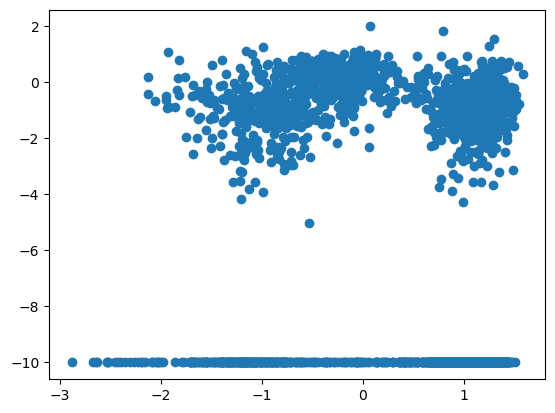

In [14]:
#let's plot this
import matplotlib.pyplot as plt
plt.scatter(y_hat.detach().cpu().numpy(), target.detach().cpu().numpy())

In [19]:
#delete lots of the variables that are on the gpu
del y_hat
del target
del seq
torch.cuda.empty_cache()

In [20]:
#let's do 5 batches of 4096
predict_list = []
target_list = []
ccre_loader = DataLoader(ccre, batch_size=2048, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
for i, batch in enumerate(ccre_loader):
    seq, target = batch
    seq = seq.to(device)
    target = target.to(device)
    y_hat, _ = backbone(seq)
    y_hat = decoder(y_hat)
    # print(y_hat)
    # print(target)
    predict_list.extend(y_hat.detach().cpu().numpy())
    target_list.extend(target.detach().cpu().numpy())
    if i == 5:
        break

print(len(predict_list))

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 GiB. GPU 0 has a total capacty of 79.18 GiB of which 1.64 GiB is free. Including non-PyTorch memory, this process has 77.54 GiB memory in use. Of the allocated memory 71.89 GiB is allocated by PyTorch, and 5.15 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
#memory issues, let's restart the kernel and try again
#it will probably be best to make the yaml the original 16 in size

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

d_output = 1

tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-07/09-47-18-698056/checkpoints/val/mse.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)

In [2]:
#find the amount of free memory
torch.cuda.memory_allocated()

1810432

In [3]:
#let's do 5 batches of 4096
from torch.utils.data import DataLoader
predict_list = []
target_list = []
# decoder = decoder.to(device)
# backbone = backbone.to(device)
ccre_loader = DataLoader(ccre, batch_size=4096, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    for i, batch in enumerate(ccre_loader):
        seq, target = batch
        seq = seq.to(device)
        target = target.to(device)
        y_hat, _ = backbone(seq)
        y_hat = decoder(y_hat)
        # print(y_hat)
        # print(target)
        predict_list.extend(y_hat.detach().cpu().numpy())
        target_list.extend(target.detach().cpu().numpy())
        if i == 5:
            break

print(len(predict_list))

24576


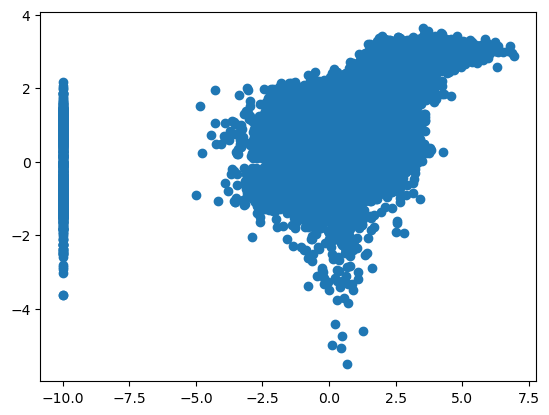

In [4]:
#now plot

import matplotlib.pyplot as plt
plt.scatter(target_list, predict_list)

Text(0, 0.5, 'predicted dnase values')

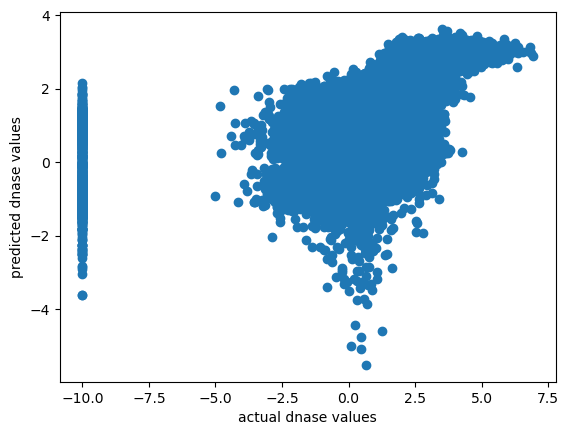

In [5]:
plt.scatter(target_list, predict_list)
plt.xlabel('actual dnase values')
plt.ylabel('predicted dnase values')

In [ ]:
#let's now do this for 

# evaluation done in DNase_midpoint.py

Now we will work on plotting the results of 2048 sized batches over 100 iterations, so 204,800 data points

In [1]:
#load in the files
import torch

predicts = torch.load('/data/leslie/sarthak/data/predict_array.pt')
targets = torch.load('/data/leslie/sarthak/data/target_array.pt')
#print the shapes
print(predicts.shape)
print(targets.shape)


torch.Size([126828660, 1])
torch.Size([126828660, 1])


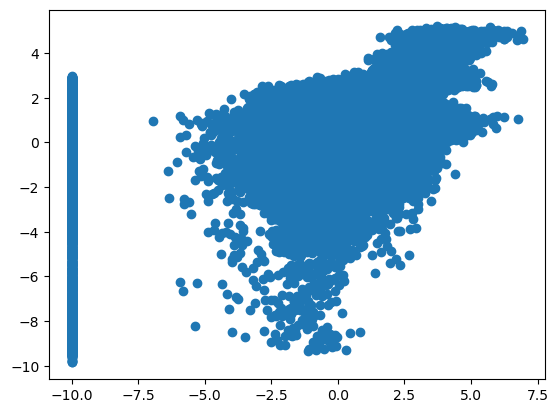

In [3]:
#let's check to make sure everything before 204800 of the array isn't 0
import matplotlib.pyplot as plt
target = targets[:204800]
predict = predicts[:204800]
plt.scatter(target, predict)

In [4]:
#and now calculate R2
from sklearn.metrics import r2_score
r2_score(target, predict)

0.2226291595907992

In [5]:
#and correlation coefficient
import numpy as np
print(np.corrcoef(target, predict))

/data/leslie/sarthak/environments/hyena-dna/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)


MemoryError: Unable to allocate 1.22 TiB for an array with shape (409600, 409600) and data type float64

In [7]:
#use scipy for pearson correlation
from scipy.stats import pearsonr
print(pearsonr(target.squeeze(), predict.squeeze()))
#it's .48, which is not great, but it's not terrible either

PearsonRResult(statistic=0.4802957077610601, pvalue=0.0)


In [8]:
#let's calculate both but ignore values where the target is -10
mask = target != -10
target = target[mask]
predict = predict[mask]
print(r2_score(target, predict))
print(pearsonr(target.squeeze(), predict.squeeze()))

-0.009871617031382618
PearsonRResult(statistic=0.4717717145420871, pvalue=0.0)


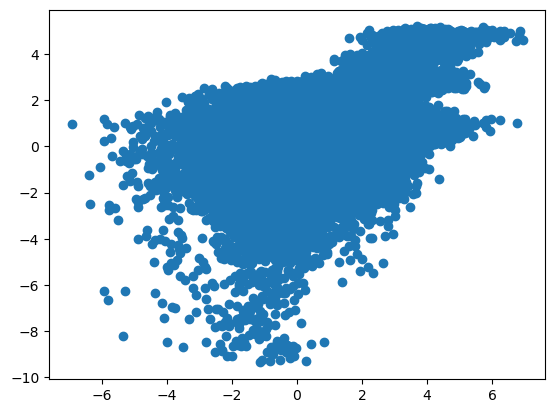

In [9]:
plt.scatter(target, predict)

In [ ]:
#we can also split by cCREs, do this by saying ccre1 is the first 1205, ccres2 is the next 1205, etc
ccre1 = targets[:1205]
ccre2 = targets[1205:2410]
ccre3 = targets[2410:3615]
ccre4 = target[3615:4820]
ccre5 = target[4820:6025]
ccre6 = target[6025:7230]
#now do 3x2 scatter plots


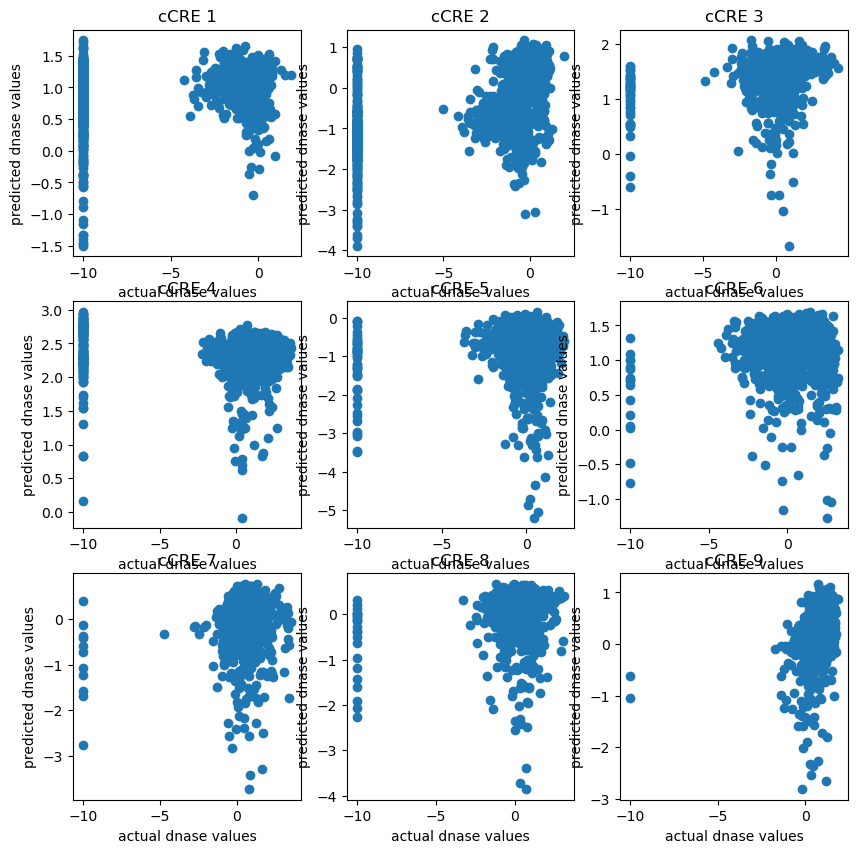

In [15]:
#better yet make it a for loop
#make a 3x2 grid
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for i in range(9):
    ccre = targets[i*1205:(i+1)*1205]
    ccre_predict = predicts[i*1205:(i+1)*1205]
    ax = axs[i//3, i%3]
    ax.scatter(ccre, ccre_predict)
    ax.set_title(f'cCRE {i+1}')
    ax.set_xlabel('actual dnase values')
    ax.set_ylabel('predicted dnase values')

In [18]:
#very quickly we'll test my new dataloader
import sys
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
tokenizer = CharacterTokenizer(
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
test = DNaseAllCellTypeDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')
print(len(test))

105252


In [19]:
a, b = test[0]
print(a.shape)
print(b.shape)

torch.Size([1023])
torch.Size([1, 1205])


In [20]:
print(b.squeeze(0).shape)

torch.Size([1205])


# evaluation on the filtered cell types

In [4]:
#the key thing is that we need to make sure we specify yes to filtering the cell types when calling the dataloader

#memory issues, let's restart the kernel and try again
#it will probably be best to make the yaml the original 16 in size

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
os.chdir('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-41-04-133078/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
# embedding = torch.nn.Embedding(20, 128)
# backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)

In [9]:
#now dataset class
from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset
DNase_all = DNaseAllCellTypeDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter=True)

#let's do 5 batches of 4096
from torch.utils.data import DataLoader
predict_list = []
target_list = []
#output shape will be N x 161
targets = torch.zeros((len(DNase_all), 161))
predicts = torch.zeros((len(DNase_all), 161))
DNase = DataLoader(DNase_all, batch_size=4096, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    idx = 0
    for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
        seq, target = batch
        seq = seq.to(device)
        b_size = seq.shape[0]
        # target = target.to(device)
        y_hat, _ = backbone(seq)
        y_hat = decoder(y_hat)
        # print(y_hat)
        # print(target)
        targets[idx:b_size+idx,:] = target
        predicts[idx:b_size+idx,:] = y_hat.detach().cpu()
        idx += b_size


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [01:09<00:00,  2.67s/it]


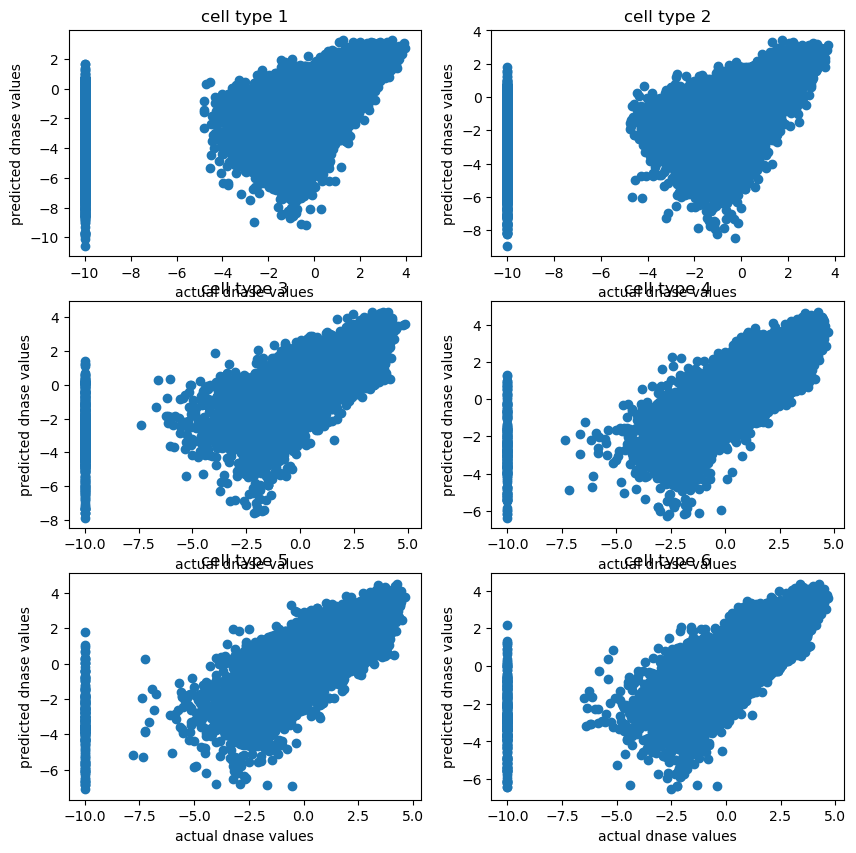

In [11]:
#do a few of the columns, show the scatter plot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    ax = axs[i//2, i%2]
    ax.scatter(targets[:,i], predicts[:,i])
    ax.set_title(f'cell type {i+1}')
    ax.set_xlabel('actual dnase values')
    ax.set_ylabel('predicted dnase values')

In [12]:
#now find the correlation with scipy
from scipy.stats import pearsonr
correlations = []
for i in range(161):
    # mask = targets
    target = targets[:,i]
    predict = predicts[:,i]
    correlations.append(pearsonr(target.squeeze(), predict.squeeze()))

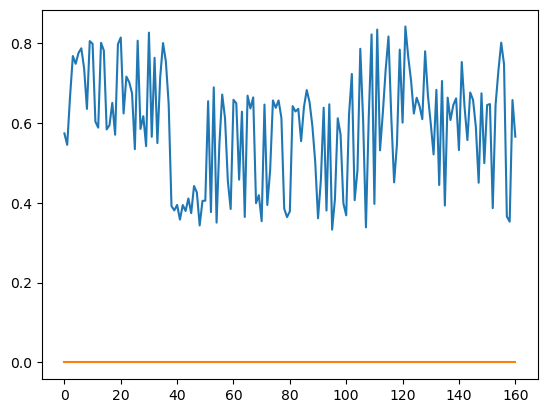

In [13]:
#plot the correlations
plt.plot(correlations)

# now we evaluate the models with 100 epochs each 10% of the data

In [1]:
#first we load them in
import torch

#this is the token model, not quite done yet... wait it's 1205 shape... oh no
predicts_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/predicts.pt')
target_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/targets.pt')

#now check the shapes
print(predicts_token.shape, target_token.shape)

torch.Size([1063878, 1205]) torch.Size([1063878, 1205])


In [10]:
#test my code

import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)
#now dataset class
# from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset
# DNase_all = DNaseAllCellTypeDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter=True)

#let's do 5 batches of 4096
from torch.utils.data import DataLoader
# predict_list = []
# target_list = []
#output shape will be N x 161
# targets = torch.zeros(ccre.cell_dnase_levels.shape)
# predicts = torch.zeros(ccre.cell_dnase_levels.shape)
targets_flat = torch.zeros(len(ccre)) #because output is just a single value, it's so obvious it's kind of stupid
predicts_flat = torch.zeros(len(ccre))
DNase = DataLoader(ccre, batch_size=4096, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    idx = 0
    for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
        seq, target = batch
        seq = seq.to(device)
        b_size = seq.shape[0]
        # target = target.to(device)
        y_hat, _ = backbone(seq)
        y_hat = decoder(y_hat)
        # print(y_hat)
        # print(target)
        targets_flat[idx:b_size+idx] = target.squeeze()
        predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
        idx += b_size
        break
    
print(targets_flat.shape)
print(predicts_flat.shape)

  0%|                                                                                                                                                                                                         | 0/4138 [00:02<?, ?it/s]

torch.Size([16945572])
torch.Size([16945572])


In [9]:
print(161*4096)

print(d_output)

print(ccre.cell_types)

print(len(ccre))

print(len(ccre)/ccre.cell_types) #number in the test set

659456
1
161
16945572
105252.0


In [12]:
targets_flat = torch.zeros(len(ccre)) #because output is just a single value, it's so obvious it's kind of stupid
predicts_flat = torch.zeros(len(ccre))
DNase = DataLoader(ccre, batch_size=4096, shuffle=False) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    idx = 0
    for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
        seq, target = batch
        seq = seq.to(device)
        b_size = seq.shape[0]
        # target = target.to(device)
        y_hat, _ = backbone(seq)
        y_hat = decoder(y_hat)
        # print(y_hat)
        # print(target)
        targets_flat[idx:b_size+idx] = target.squeeze()
        predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
        idx += b_size
        if i == 100:
            break

#now remove anything including that would be the last row of the reshape
if idx % 161 != 0:
    idx = idx - (idx % 161)
targets_flat = targets_flat[:idx]
predicts_flat = predicts_flat[:idx]

#now reshape
targets = targets_flat.reshape(-1, 161)
predicts = predicts_flat.reshape(-1, 161)

  0%|                                                                                                                                                                                                         | 0/4138 [00:00<?, ?it/s]

  2%|████▌                                                                                                                                                                                        | 100/4138 [04:26<2:59:30,  2.67s/it]


In [13]:
print(targets.shape, predicts.shape)

torch.Size([2569, 161]) torch.Size([2569, 161])


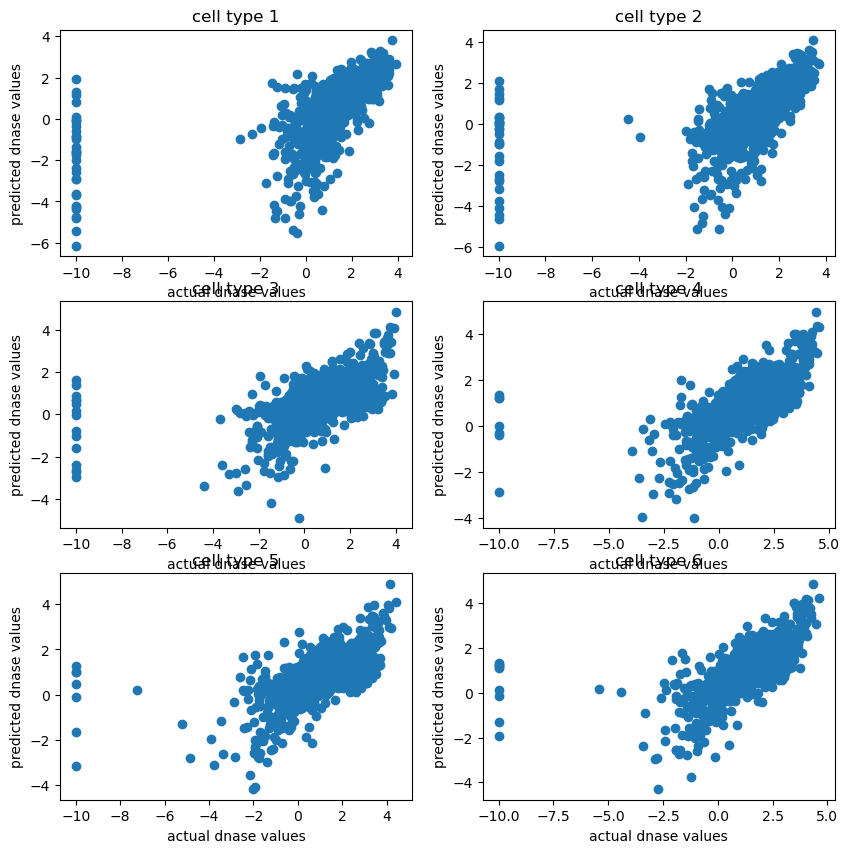

In [14]:
#plot the first 6 cell types
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    ax = axs[i//2, i%2]
    ax.scatter(targets[:,i], predicts[:,i])
    ax.set_title(f'cell type {i+1}')
    ax.set_xlabel('actual dnase values')
    ax.set_ylabel('predicted dnase values')

In [15]:
#calculate the pearson correlation
from scipy.stats import pearsonr
correlations = []
for i in range(161):
    # mask = targets
    target = targets[:,i]
    predict = predicts[:,i]
    correlations.append(pearsonr(target.squeeze(), predict.squeeze()))

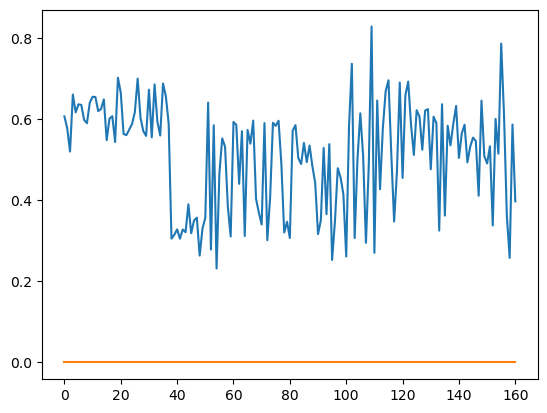

In [16]:
#plot it
plt.plot(correlations)

In [17]:
#load in the other data
targets_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/targets.pt')
predicts_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/predicts.pt')

#print the shape
print(targets_all.shape, predicts_all.shape)

torch.Size([105252, 161]) torch.Size([105252, 161])


In [18]:
#only use the first 2569 rows
targets_all = targets_all[:2569]
predicts_all = predicts_all[:2569]

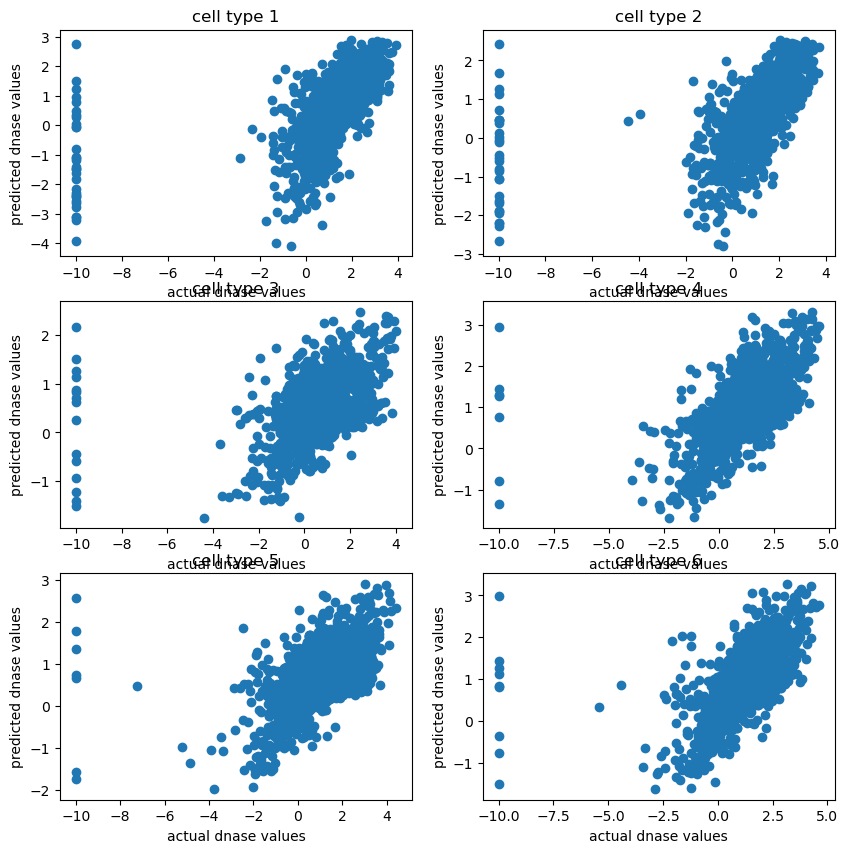

In [19]:
#again plot the first 6 cell types
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
for i in range(6):
    ax = axs[i//2, i%2]
    ax.scatter(targets_all[:,i], predicts_all[:,i])
    ax.set_title(f'cell type {i+1}')
    ax.set_xlabel('actual dnase values')
    ax.set_ylabel('predicted dnase values')

In [20]:
#and correlations
corr_list_all = []
for i in range(161):
    # mask = targets
    target = targets_all[:,i]
    predict = predicts_all[:,i]
    # print(pearsonr(target.squeeze(), predict.squeeze()))
    corr_list_all.append(pearsonr(target.squeeze(), predict.squeeze()))

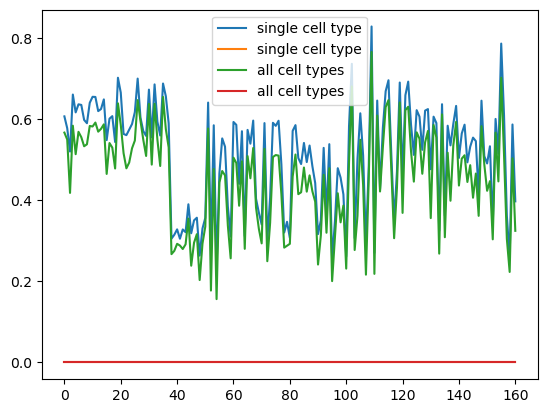

In [25]:
#let's plot both of the correlations on the same plot
plt.plot(correlations, label = 'single cell type')
plt.plot(corr_list_all, label = 'all cell types')
plt.legend()

In [30]:
print(correlations)
print(correlations[0].statistic)
print(correlations.statistic)

[PearsonRResult(statistic=0.6072951134835378, pvalue=8.343205871264465e-259), PearsonRResult(statistic=0.5781911563266351, pvalue=4.0607611108903145e-229), PearsonRResult(statistic=0.5205581148441956, pvalue=2.021914823843504e-178), PearsonRResult(statistic=0.6611328492501107, pvalue=1.2e-322), PearsonRResult(statistic=0.6171516817918862, pvalue=1.422133310512342e-269), PearsonRResult(statistic=0.6370461480682008, pvalue=1.6189931757379166e-292), PearsonRResult(statistic=0.6355652006040232, pvalue=9.45238274957946e-291), PearsonRResult(statistic=0.5985518009124742, pvalue=1.4504393320149764e-249), PearsonRResult(statistic=0.5904078243274408, pvalue=3.2751180385075604e-241), PearsonRResult(statistic=0.6407727265953943, pvalue=5.264964212242955e-297), PearsonRResult(statistic=0.6555806959223471, pvalue=1.79845978e-315), PearsonRResult(statistic=0.6552310519846125, pvalue=5.046423166e-315), PearsonRResult(statistic=0.6202975271352796, pvalue=4.313579869699012e-273), PearsonRResult(statist

AttributeError: 'list' object has no attribute 'statistic'

In [32]:
#loop through and just get the statistics
correlation_stats = []
for stat in correlations:
    correlation_stats.append(stat.statistic)
    
#and for the other
correlation_stats_all = []
for stat in corr_list_all:
    correlation_stats_all.append(stat.statistic)

Text(0, 0.5, 'pearson correlation coefficient')

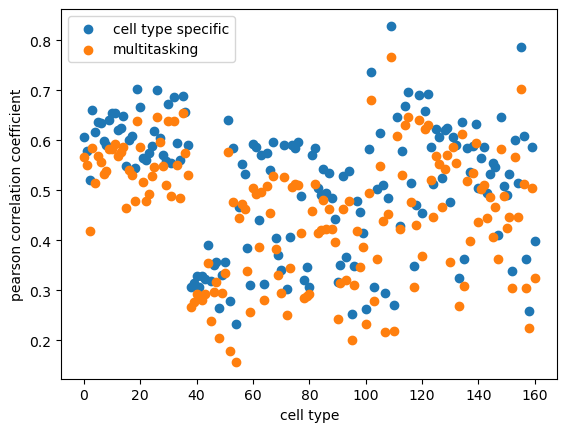

In [35]:
#use scatter plot instead to show them per cell type
myrange = range(161)
plt.scatter(myrange, correlation_stats, label = 'cell type specific')
plt.scatter(myrange, correlation_stats_all, label = 'multitasking')
plt.legend()
plt.xlabel('cell type')
plt.ylabel('pearson correlation coefficient')

Text(0.5, 0, 'multitasking')

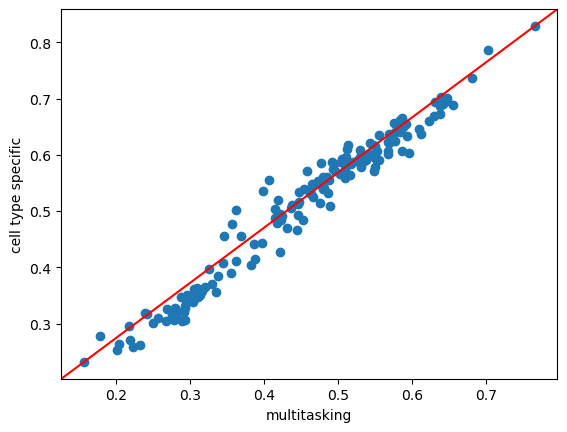

In [37]:
#now scatter cell type specific vs multitasking
plt.scatter(correlation_stats_all, correlation_stats)
#also the line y=x
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='r')
plt.ylabel('cell type specific')
plt.xlabel('multitasking')


In [38]:
#now plot correlations for each row instead of the columns
corr_row = []
for i in range(2569):
    target = targets[i,:]
    predict = predicts[i,:]
    corr_row.append(pearsonr(target, predict).statistic)
    
corr_row_all = []
for i in range(2569):
    target = targets_all[i,:]
    predict = predicts_all[i,:]
    corr_row_all.append(pearsonr(target, predict).statistic)

Text(0.5, 1.0, 'correlation for each cCRE')

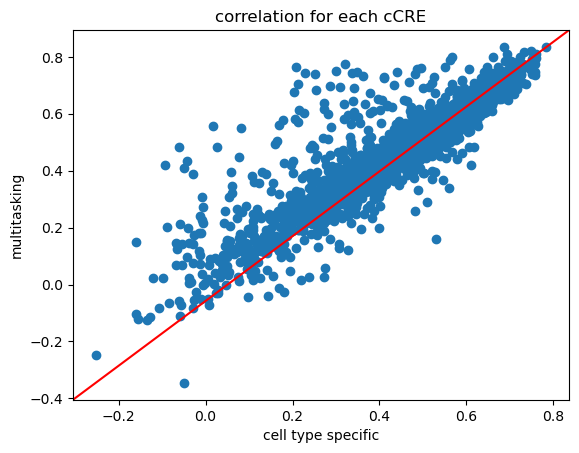

In [44]:
#now scatter
plt.scatter(corr_row, corr_row_all)
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
#and the 11 line
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='r')
plt.title('correlation for each cCRE')

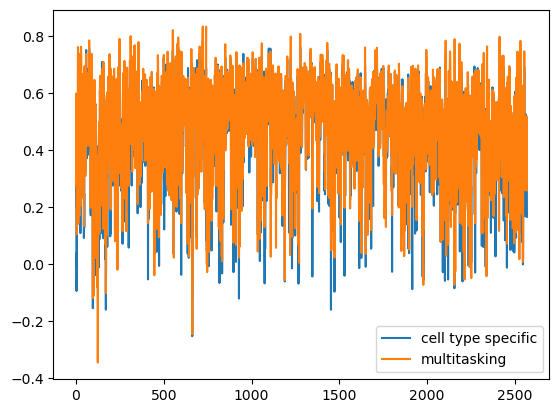

In [43]:
#let's do a plt.plot like before
plt.plot(corr_row, label = 'cell type specific')
plt.plot(corr_row_all, label = 'multitasking')
plt.legend()

In [46]:
#calculate mse between target and predict
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, predicts)
print(mse)

2.8294957


In [48]:
#and for the other one
mse_all = mean_squared_error(targets_all, predicts_all)
print(mse_all)

2.9638782


# repeating but ensuring it's proper

In [1]:
import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

decoder = decoder.to(device)
backbone = backbone.to(device)

In [5]:
from torch.utils.data import DataLoader


targets_flat = torch.zeros(len(ccre)) #because output is just a single value, it's so obvious it's kind of stupid
predicts_flat = torch.zeros(len(ccre))
DNase = DataLoader(ccre, batch_size=4096, shuffle=False, num_workers=4) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    idx = 0
    for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
        seq, target = batch
        seq = seq.to(device)
        b_size = seq.shape[0]
        # target = target.to(device)
        y_hat, _ = backbone(seq)
        y_hat = decoder(y_hat)
        # print(y_hat)
        # print(target)
        targets_flat[idx:b_size+idx] = target.squeeze()
        predicts_flat[idx:b_size+idx] = y_hat.detach().cpu().squeeze()
        idx += b_size
        # if i == 1000:
        #     break

#now remove anything including that would be the last row of the reshape
# if idx % 161 != 0:
#     idx = idx - (idx % 161)
# targets_flat = targets_flat[:idx]
# predicts_flat = predicts_flat[:idx]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4138/4138 [1:16:14<00:00,  1.11s/it]


NameError: name 'targets' is not defined

In [9]:
# #now reshape
print(idx)
print(len(ccre)) #glad to know it matches
targets = targets_flat.reshape(-1, 161)
predicts = predicts_flat.reshape(-1, 161)

print(targets.shape, predicts.shape)

#load in the other data
targets_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/targets.pt')
predicts_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/predicts.pt')

#print the shape
print(targets_all.shape, predicts_all.shape)
#only use the first 2569 rows
# targets_all = targets_all[:2569]
# predicts_all = predicts_all[:2569]

# print(targets_all.shape, predicts_all.shape)

#takes like 75 min
print(ccre.cell_dnase_levels.shape) #but this is all the test and val too

16945572
16945572
torch.Size([105252, 161]) torch.Size([105252, 161])
torch.Size([105252, 161]) torch.Size([105252, 161])
(1063878, 1205)


In [10]:
#now let's calculate the global mse
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(targets, predicts)
print(mse)
mse2 = mean_squared_error(targets_all, predicts_all)
print(mse2)
#mse is a bit lower for cell type specific

3.4002197
3.614632


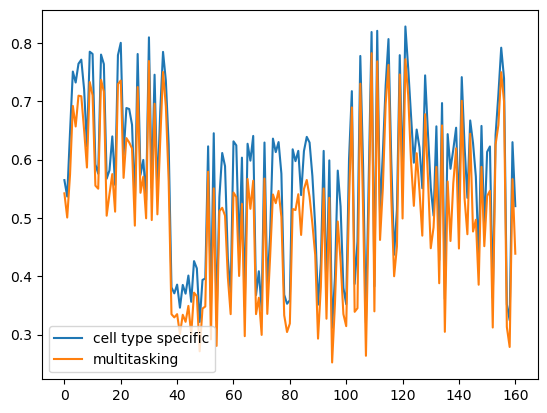

In [12]:
#now we can calculate the pearson correlation
from scipy.stats import pearsonr
correlations = []
for i in range(161):
    # mask = targets
    target = targets[:,i]
    predict = predicts[:,i]
    correlations.append(pearsonr(target.squeeze(), predict.squeeze()).statistic)

#and the other one
correlations_all = []
for i in range(161):
    # mask = targets
    target = targets_all[:,i]
    predict = predicts_all[:,i]
    correlations_all.append(pearsonr(target.squeeze(), predict.squeeze()).statistic)
import matplotlib.pyplot as plt
#and plot both
plt.plot(correlations, label = 'cell type specific')
plt.plot(correlations_all, label = 'multitasking')
plt.legend()

In [13]:
#now find the number that are greater
greater = 0
for i in range(161):
    if correlations[i] > correlations_all[i]:
        greater += 1
print(greater)
#every single one??

161


Text(0.5, 1.0, 'correlation for each cell type')

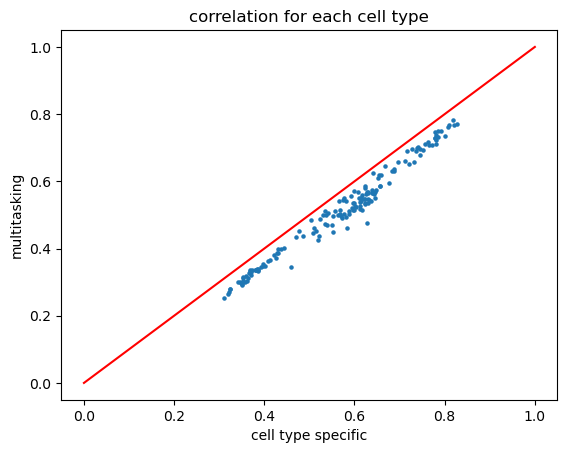

In [57]:
#now let's do a scatter plot
plt.scatter(correlations, correlations_all, s = 5)
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
#and the 11 line
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='r')
plt.plot([0, 1], [0, 1], c='r')
plt.title('correlation for each cell type')

In [16]:
#and again for all the ccres
corr_row = []
for i in range(105252):
    target = targets[i,:]
    predict = predicts[i,:]
    corr_row.append(pearsonr(target, predict).statistic)

corr_row_all = []
for i in range(105252):
    target = targets_all[i,:]
    predict = predicts_all[i,:]
    corr_row_all.append(pearsonr(target, predict).statistic)

Text(0.5, 1.0, 'correlation for each cCRE')

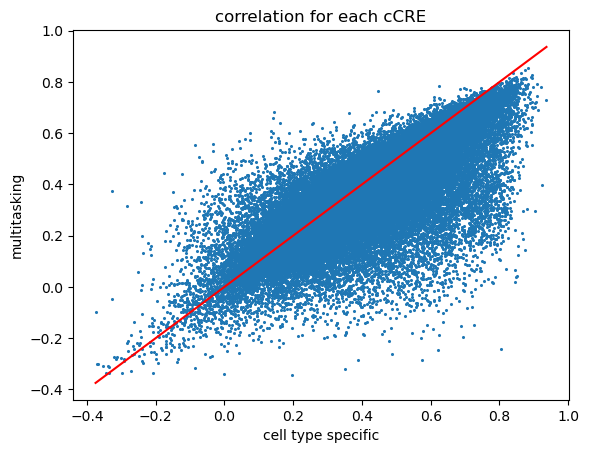

In [22]:
#and we will again plot it
import numpy as np
plt.scatter(corr_row, corr_row_all, s=1.5)
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
#and the 11 line, but go from minimum to maximum
# plt.plot([0, 1], [0, 1], c='r')
min = np.min([np.min(corr_row), np.min(corr_row_all)])
max = np.max([np.max(corr_row), np.max(corr_row_all)])
plt.plot([min, max], [min, max], c='r')
plt.title('correlation for each cCRE')


In [17]:
#oh very quickly, let's save out targets and predicts
torch.save(targets, '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/targets_92epoch.pt') #since only done 92 epoch
torch.save(predicts, '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/predicts_92epoch.pt')

In [26]:
#find the number of ccres that are higher correlation
greater = 0
for i in range(105252):
    if np.abs(corr_row[i]) > np.abs(corr_row_all[i]):
        greater += 1
print(greater)
print(len(corr_row))
print(greater/len(corr_row)) #633

66708
105252
0.6337931820773002


In [30]:
#let's do a density plot instead of the scatter, scatter plot colored by density
from scipy.stats import gaussian_kde

xy = np.vstack([corr_row, corr_row_all])
z = gaussian_kde(xy)(xy)

AttributeError: 'Axes' object has no attribute 'colorbar'

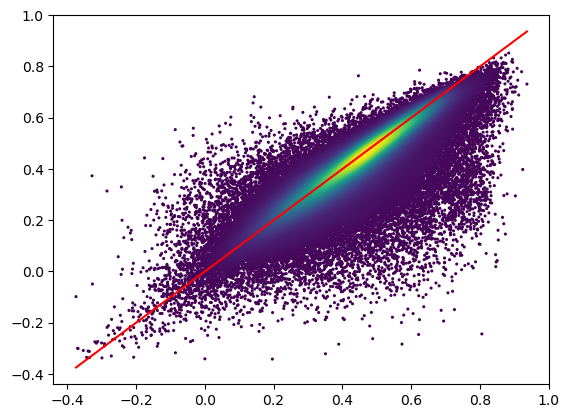

In [37]:
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z2 = np.array(corr_row)[idx], np.array(corr_row_all)[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z2, s=1.5)
ax.plot([min, max], [min, max], c='r')
# ax.colorbar()
plt.show()

Text(0.5, 1.0, 'correlation for each cCRE, colored by density')

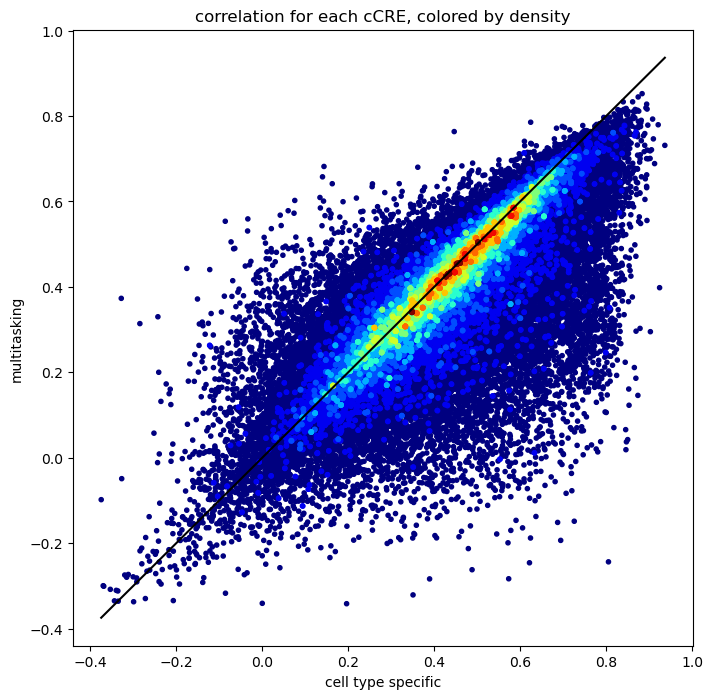

In [44]:
x,y = np.array(corr_row), np.array(corr_row_all)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([min, max], [min, max], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('correlation for each cCRE, colored by density')

In [45]:
#to ensure we're correct, make sure targets and targets_all are the same
print(torch.all(targets == targets_all))
#they're the same matrix obviously!

tensor(True)


Text(0.5, 1.0, 'histogram of correlations per cell type')

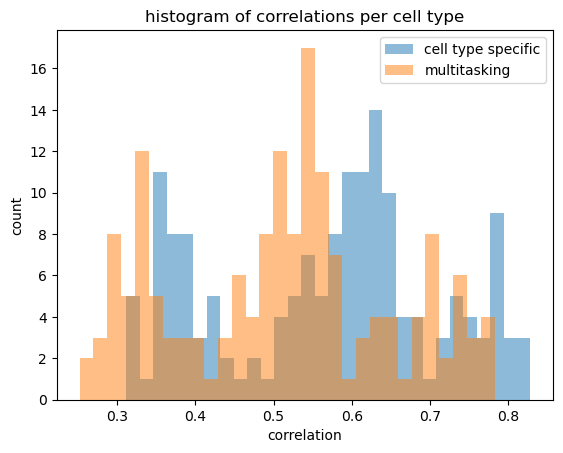

In [62]:
#let's do histograms of the correlations
plt.hist(correlations, bins = 30, alpha = 0.5, label = 'cell type specific')
plt.hist(correlations_all, bins = 30, alpha = 0.5, label = 'multitasking')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('histogram of correlations per cell type')

Text(0.5, 1.0, 'histogram of correlations per cCRE')

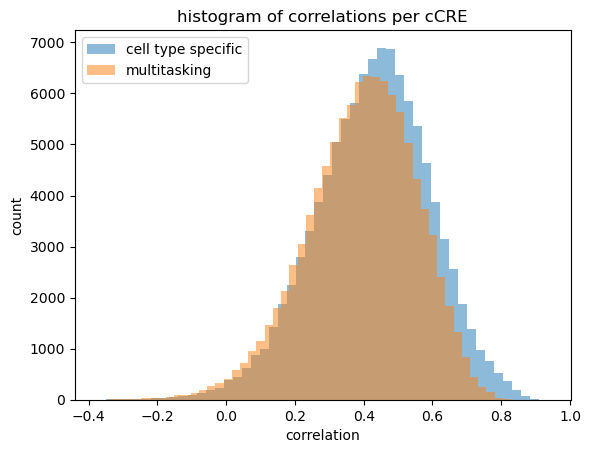

In [50]:
#and for the rows
plt.hist(corr_row, bins = 50, alpha = 0.5, label = 'cell type specific')
plt.hist(corr_row_all, bins = 50, alpha = 0.5, label = 'multitasking')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('histogram of correlations per cCRE')

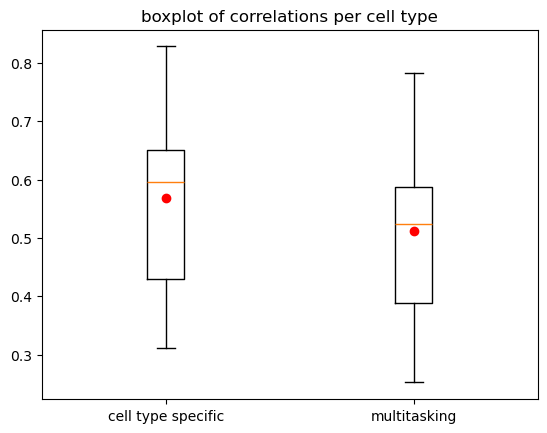

In [63]:
#and boxplots
plt.boxplot([correlations, correlations_all])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cell type')
#include the mean
plt.scatter([1, 2], [np.mean(correlations), np.mean(correlations_all)], c = 'r')
#add the bar and the star on top to show the significance

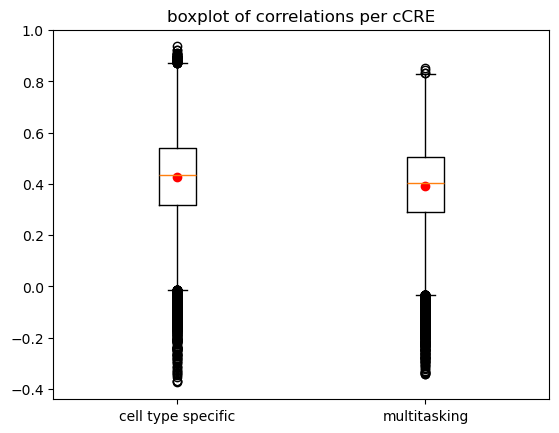

In [64]:
#and for the rows
plt.boxplot([corr_row, corr_row_all])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cCRE')
#agian add means
plt.scatter([1, 2], [np.mean(corr_row), np.mean(corr_row_all)], c = 'r')
#and add star

In [60]:
#also do some sort of statistical test, see what sklearn has
#look into this like if have scatter plot 2 distributions and want to test if significantly more in one side than another
#let's start with a basic t test
from scipy.stats import ttest_ind
p=ttest_ind(correlations, correlations_all) #still a pretty small p value
print(p)

p2=ttest_ind(corr_row, corr_row_all)
print(p2)

TtestResult(statistic=3.6322199600478853, pvalue=0.00032714676541312514, df=320.0)
TtestResult(statistic=46.91174505650776, pvalue=0.0, df=210502.0)


# redo but with the full models for the abstract
Now load it in, we evaluated using a job and our script

In [52]:
#first load in the results
import torch
target_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/targets.pt')
predict_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/predicts.pt')

targets_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/targets.pt')
predicts_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/predicts.pt')

#verify the labels are the same
print(torch.all(target_token == targets_all))

tensor(True)


In [53]:
#we can just use on target
t = target_token

In [3]:
#now we can calculate the mse
from sklearn.metrics import mean_squared_error
mse1 = mean_squared_error(target, predict_token)
mse2 = mean_squared_error(targets_all, predicts_all)
print(mse1, mse2) #token does a decent amount better, about the same as before, actually slightly worse

3.4015665 3.614632


In [60]:
#now let's calculate correlations along rows and columns
from scipy.stats import pearsonr
token_celltype = []
all_celltype = []
for i in range(161):
    target = t[:,i]
    predict = predict_token[:,i]
    token_celltype.append(pearsonr(target, predict).statistic)
    target = t[:,i]
    predict = predicts_all[:,i]
    all_celltype.append(pearsonr(target, predict).statistic)

token_ccre = []
all_ccre = []
for i in range(target.shape[0]):
    target = t[i,:]
    predict = predict_token[i,:]
    token_ccre.append(pearsonr(target, predict).statistic)
    target = t[i,:]
    predict = predicts_all[i,:]
    all_ccre.append(pearsonr(target, predict).statistic)
    
#an dlen of lists
print(len(token_celltype), len(all_celltype), len(token_ccre), len(all_ccre))

161 161 105252 105252


Text(0.5, 1.0, 'correlation for each cell type')

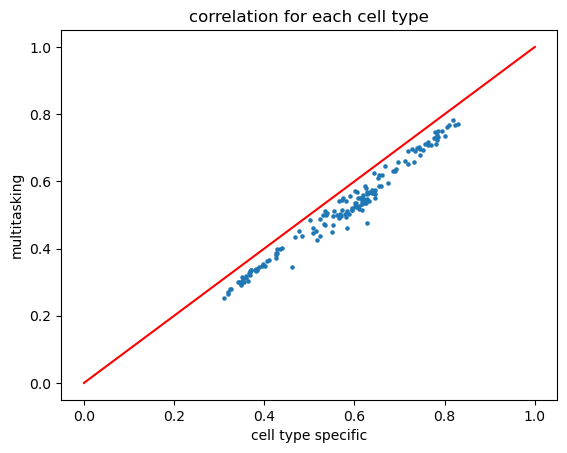

In [10]:
import matplotlib.pyplot as plt
import numpy as np
#now let's do a scatter plot
plt.scatter(token_celltype, all_celltype, s = 5)
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
#and the 11 line
# plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, c='r')
plt.plot([0, 1], [0, 1], c='r')
plt.title('correlation for each cell type')

Text(0.5, 1.0, 'correlation for each celltype')

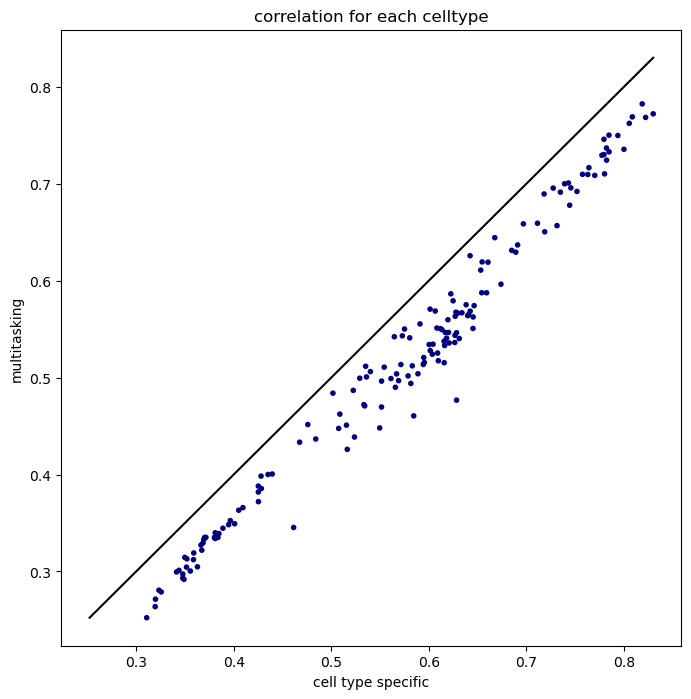

In [14]:
x,y = np.array(token_celltype), np.array(all_celltype)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('correlation for each celltype')

Text(0.5, 1.0, 'correlation for each cCRE, colored by density')

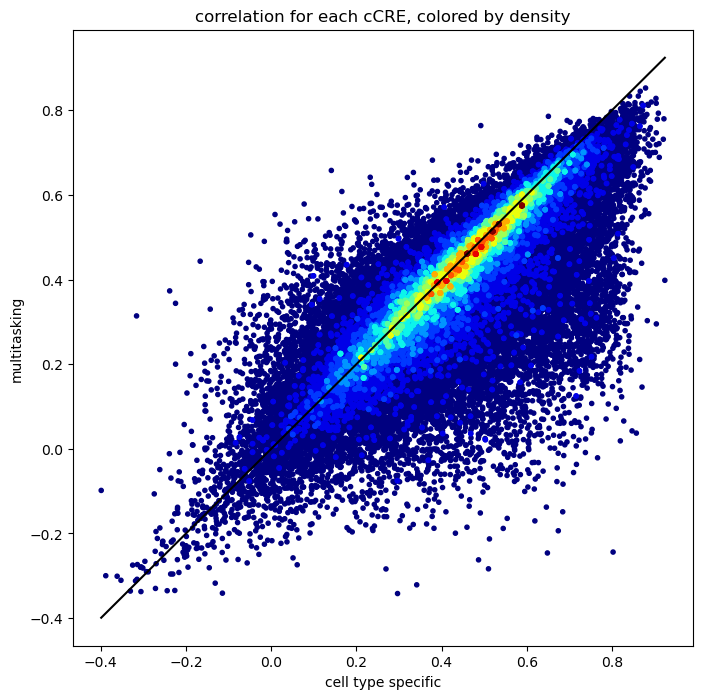

In [13]:
x,y = np.array(token_ccre), np.array(all_ccre)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('correlation for each cCRE, colored by density')

In [69]:
#find the number of ccres that are higher correlation
greater = 0
for i in range(105252):
    if np.abs(token_ccre[i]) > np.abs(all_ccre[i]):
        greater += 1
print(greater)
print(len(token_ccre))
print(greater/len(token_ccre)) #6419

67564
105252
0.641926044160681


Text(0.5, 1.0, 'histogram of correlations per cell type')

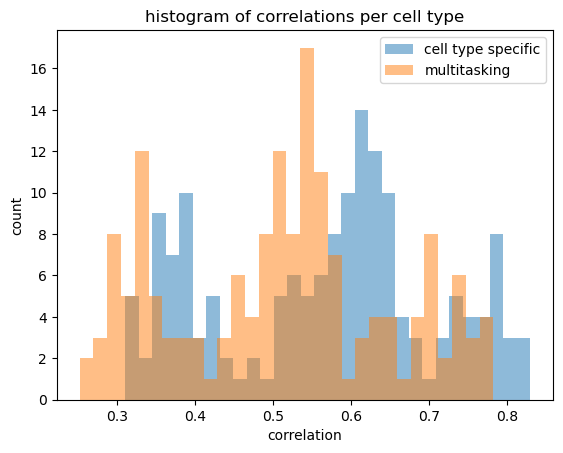

In [16]:
#let's do histograms of the correlations
plt.hist(token_celltype, bins = 30, alpha = 0.5, label = 'cell type specific')
plt.hist(all_celltype, bins = 30, alpha = 0.5, label = 'multitasking')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('histogram of correlations per cell type')

Text(0.5, 1.0, 'histogram of correlations per cCRE')

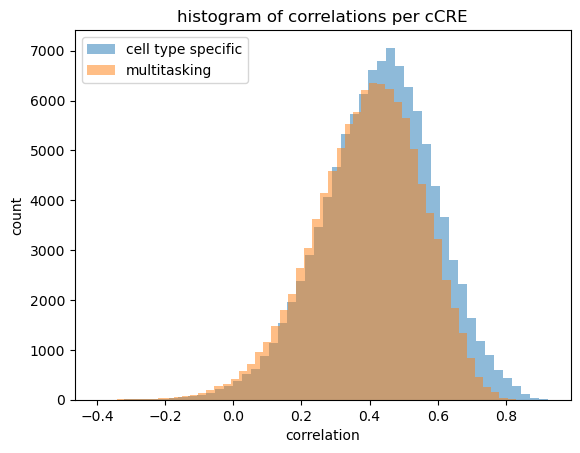

In [17]:
#and for the rows
plt.hist(token_ccre, bins = 50, alpha = 0.5, label = 'cell type specific')
plt.hist(all_ccre, bins = 50, alpha = 0.5, label = 'multitasking')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('histogram of correlations per cCRE')

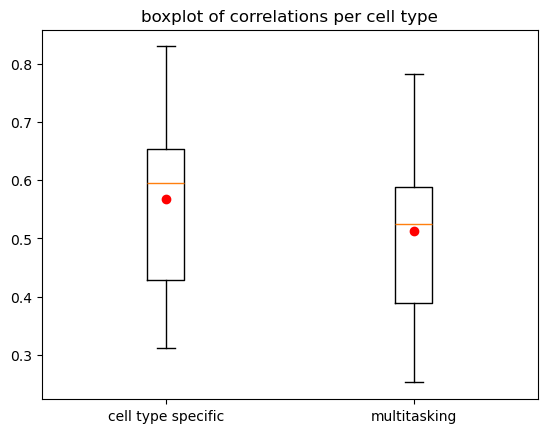

In [20]:
#and boxplots
plt.boxplot([token_celltype, all_celltype])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cell type')
#include the mean
plt.scatter([1, 2], [np.mean(token_celltype), np.mean(all_celltype)], c = 'r')
#add the bar and the star on top to show the significance

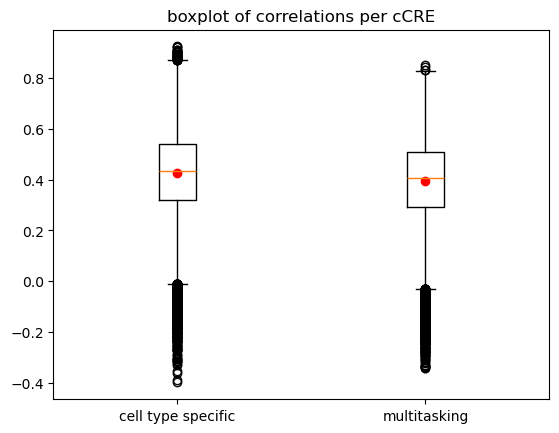

In [21]:
#and for the rows
plt.boxplot([token_ccre, all_ccre])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cCRE')
#agian add means
plt.scatter([1, 2], [np.mean(token_ccre), np.mean(all_ccre)], c = 'r')
#and add star

In [23]:
#let's do a mann whitney u test
from scipy.stats import mannwhitneyu
p = mannwhitneyu(token_celltype, all_celltype)
from scipy.stats import ttest_ind
p2 = ttest_ind(token_ccre, all_ccre)
print(p, p2)

MannwhitneyuResult(statistic=16225.0, pvalue=9.320519751413107e-05) TtestResult(statistic=46.99731007209682, pvalue=0.0, df=210502.0)


In [25]:
#let's now do a paired test
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
p = wilcoxon(token_celltype, all_celltype)
p2 = ttest_rel(token_ccre, all_ccre)
print(p,p2)

WilcoxonResult(statistic=0.0, pvalue=3.5900740754144804e-28) TtestResult(statistic=111.89606144430692, pvalue=0.0, df=105251)


In [27]:
p2.pvalue

True

Text(0, 0.5, 'pearson correlation')

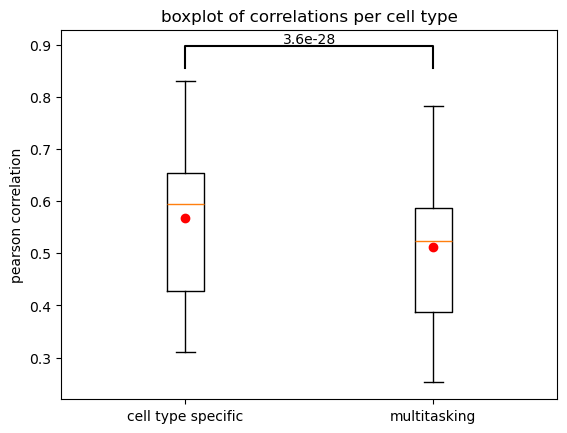

In [42]:
#do the first boxplot with the star
plt.boxplot([token_celltype, all_celltype])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cell type')
#include the mean
plt.scatter([1, 2], [np.mean(token_celltype), np.mean(all_celltype)], c = 'r')
#add the bar and the star on top to show the significance
def draw_significance_bracket(x1, x2, y, height, text, ax):
    """
    Draws a bracket to signify statistical significance between two groups.

    Parameters:
    - x1, x2: The x positions of the two groups to compare.
    - y: The y position of the top of the bracket.
    - height: The height of the bracket.
    - text: The text to display over the bracket, often '*' for significance.
    - ax: The axis object to draw on.
    """
    ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c='black')
    ax.text((x1+x2)*0.5, y+height, text, ha='center', va='bottom', color='black')

# Choose appropriate y and height for the bracket based on your data range
max_data = max(np.max(token_celltype), np.max(all_celltype))
y = max_data + max_data * 0.03  # Adjust y to be above your data
height = max_data * 0.05  # Adjust height as needed

# Call the function to draw the bracket
draw_significance_bracket(1, 2, y, height, '{:.1e}'.format(p.pvalue), plt.gca())

plt.ylabel('pearson correlation')


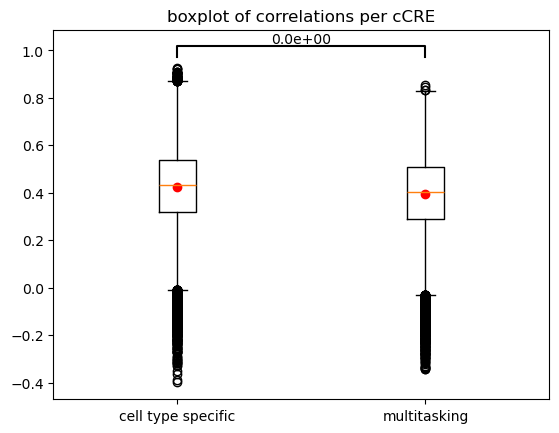

In [45]:
plt.boxplot([token_ccre, all_ccre])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of correlations per cCRE')
#agian add means
plt.scatter([1, 2], [np.mean(token_ccre), np.mean(all_ccre)], c = 'r')

max_data = max(np.max(token_ccre), np.max(all_ccre))
y = max_data + max_data * 0.05  # Adjust y to be above your data
height = max_data * 0.05  # Adjust height as needed

# Call the function to draw the bracket
draw_significance_bracket(1, 2, y, height, '{:.1e}'.format(p2.pvalue), plt.gca())

Text(0.5, 1.0, 'Histogram of correlations per cell type')

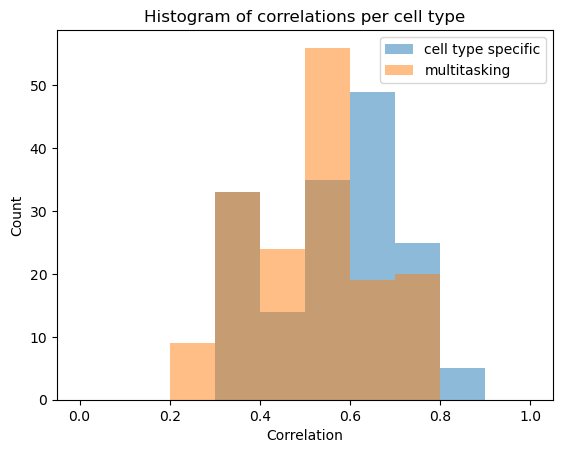

In [61]:
#let's do histograms of the correlations
import matplotlib.pyplot as plt

# Define bin edges
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# Plot histograms
plt.hist(token_celltype, bins=bins, alpha=0.5, label='cell type specific')
plt.hist(all_celltype, bins=bins, alpha=0.5, label='multitasking')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of correlations per cell type')


Text(0.5, 1.0, 'Histogram of correlations per cell type')

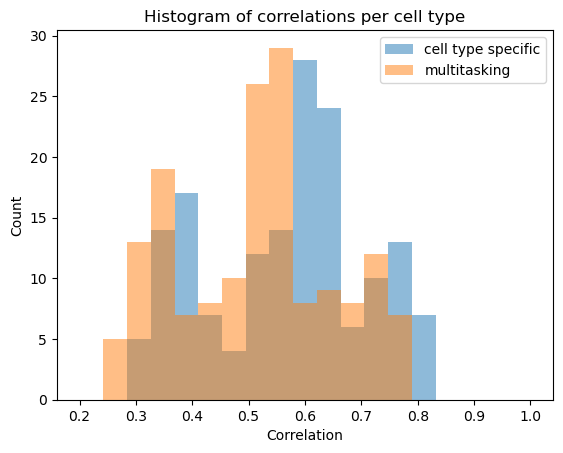

In [66]:
#let's make more bins

bins = np.linspace(0.2,1,20)

plt.hist(token_celltype, bins=bins, alpha=0.5, label='cell type specific')
plt.hist(all_celltype, bins=bins, alpha=0.5, label='multitasking')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of correlations per cell type')

# final plots repeated but with mse

In [1]:
#load it in again
import torch
import matplotlib.pyplot as plt
import numpy as np

#first load in the results
import torch
target_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/targets.pt')
predict_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/predicts.pt')

targets_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/targets.pt')
predicts_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/predicts.pt')

#verify the labels are the same
print(torch.all(target_token == targets_all))
#we can just use on target
t = target_token

#now calculate mse
mse1 = (t-predict_token)**2
mse2 = (targets_all-predicts_all)**2
print(mse1.shape, mse2.shape)

tensor(True)
torch.Size([105252, 161]) torch.Size([105252, 161])


In [2]:
#now we can average along the rows and columns to see similar charts
token_celltype = torch.mean(mse1, dim = 0)
token_ccre = torch.mean(mse1, dim = 1)

all_celltype = torch.mean(mse2, dim = 0)
all_ccre = torch.mean(mse2, dim = 1)

#print all the shapes
print(token_celltype.shape, token_ccre.shape, all_celltype.shape, all_ccre.shape)

torch.Size([161]) torch.Size([105252]) torch.Size([161]) torch.Size([105252])


Text(0.5, 1.0, 'mse for each celltype')

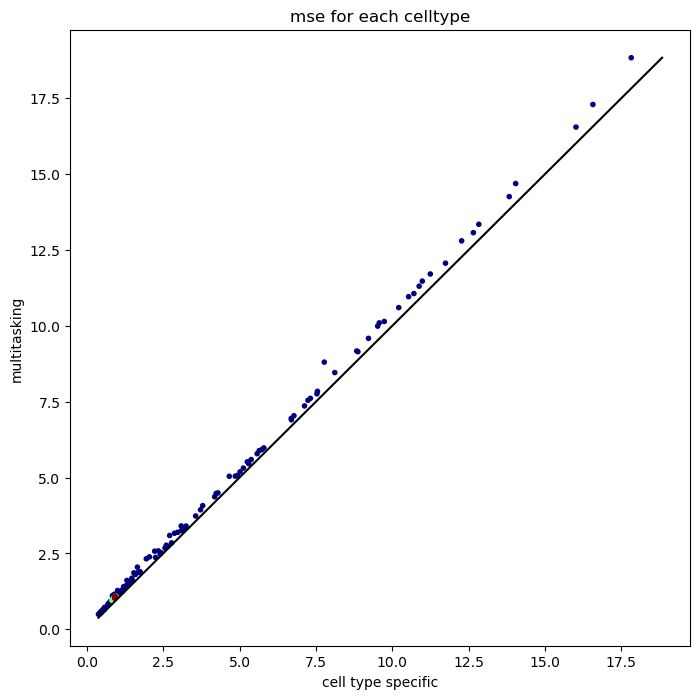

In [5]:
#now repeat the plots
x,y = np.array(token_celltype), np.array(all_celltype)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('mse for each celltype')

39509
105252
0.37537528978071677


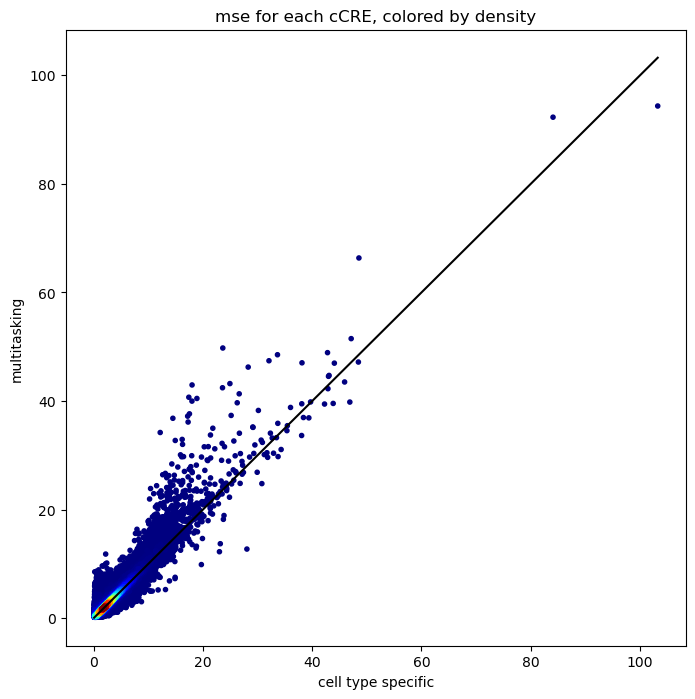

In [6]:
x,y = np.array(token_ccre), np.array(all_ccre)
bins = [1000, 1000] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('mse for each cCRE, colored by density')
#find the number of ccres that are higher correlation
greater = 0
for i in range(105252):
    if np.abs(token_ccre[i]) > np.abs(all_ccre[i]):
        greater += 1
print(greater)
print(len(token_ccre))
print(greater/len(token_ccre)) #6419

Text(0.5, 1.0, 'mse for each cCRE, colored by density, and log axes')

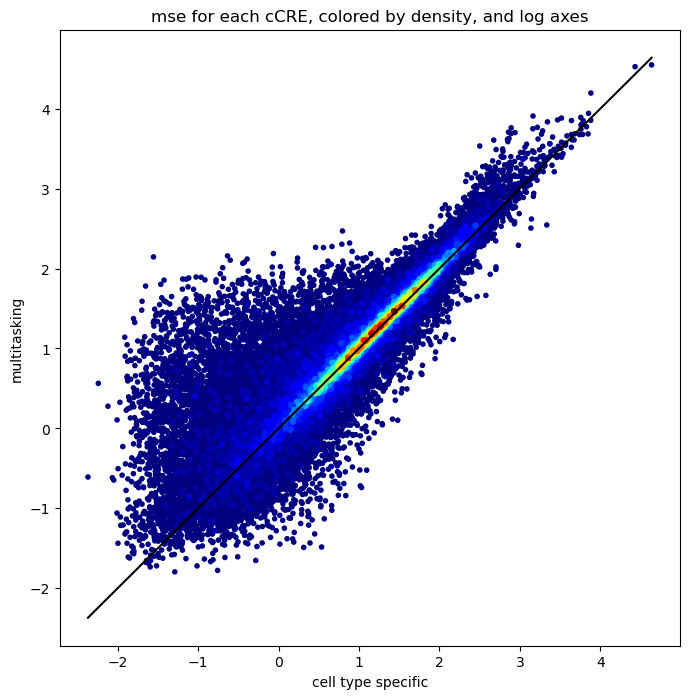

In [11]:
#log the axes
x,y = np.array(token_ccre), np.array(all_ccre)
bins = [1000, 1000] # number of bins

x, y = np.log(x + 1e-10), np.log(y + 1e-10)

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

plt.figure(1,figsize=(8,8)).clf()
s = plt.scatter(x2, y2, c=z2, cmap='jet', marker='.')
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  
# plt.colorbar()
plt.xlabel('cell type specific')
plt.ylabel('multitasking')
plt.title('mse for each cCRE, colored by density, and log axes')
#find the number of ccres that are higher correlation
#now we log the axes
# plt.xscale('log')
# plt.yscale('log')

In [12]:
#let's do a mann whitney u test
from scipy.stats import mannwhitneyu
p = mannwhitneyu(token_celltype, all_celltype)
from scipy.stats import ttest_ind
p2 = ttest_ind(token_ccre, all_ccre)
print(p, p2)
#let's now do a paired test
from scipy.stats import wilcoxon
from scipy.stats import ttest_rel
p = wilcoxon(token_celltype, all_celltype)
p2 = ttest_rel(token_ccre, all_ccre)
print(p,p2)

MannwhitneyuResult(statistic=11465.0, pvalue=0.07348595338591214) TtestResult(statistic=-18.561765718620666, pvalue=7.548478359143027e-77, df=210502.0)
WilcoxonResult(statistic=0.0, pvalue=3.5900740754144804e-28) TtestResult(statistic=-84.18432195749652, pvalue=0.0, df=105251)


In [13]:
p.statistic

0.0

Text(0, 0.5, 'mse')

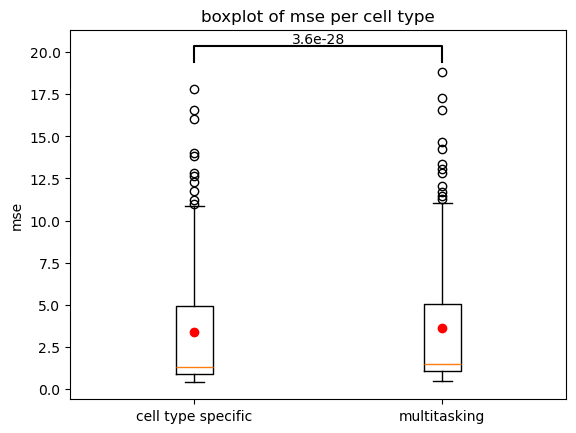

In [21]:
#do the first boxplot with the star
plt.boxplot([token_celltype, all_celltype])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of mse per cell type')
#include the mean
plt.scatter([1, 2], [torch.mean(token_celltype), torch.mean(all_celltype)], c = 'r')
#add the bar and the star on top to show the significance
def draw_significance_bracket(x1, x2, y, height, text, ax):
    """
    Draws a bracket to signify statistical significance between two groups.

    Parameters:
    - x1, x2: The x positions of the two groups to compare.
    - y: The y position of the top of the bracket.
    - height: The height of the bracket.
    - text: The text to display over the bracket, often '*' for significance.
    - ax: The axis object to draw on.
    """
    ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], lw=1.5, c='black')
    ax.text((x1+x2)*0.5, y+height, text, ha='center', va='bottom', color='black')

# Choose appropriate y and height for the bracket based on your data range
max_data = max(torch.max(token_celltype), torch.max(all_celltype))
y = max_data + max_data * 0.03  # Adjust y to be above your data
height = max_data * 0.05  # Adjust height as needed

# Call the function to draw the bracket
draw_significance_bracket(1, 2, y, height, '{:.1e}'.format(p.pvalue), plt.gca())

plt.ylabel('mse')


In [22]:
import numpy as np

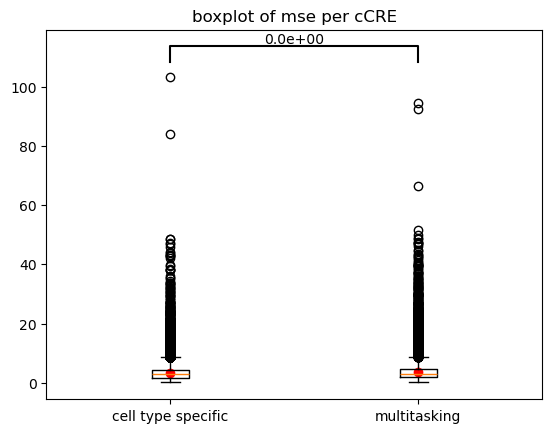

In [34]:
# token_ccre = token_ccre.numpy()
# all_ccre = all_ccre.numpy()
plt.boxplot([token_ccre, all_ccre])
plt.xticks([1, 2], ['cell type specific', 'multitasking'])
plt.title('boxplot of mse per cCRE')
#agian add means
plt.scatter([1, 2], [np.mean(token_ccre), np.mean(all_ccre)], c = 'r')

max_data = max(np.max(token_ccre), np.max(all_ccre))
y = max_data + max_data * 0.05  # Adjust y to be above your data
height = max_data * 0.05  # Adjust height as needed

# Call the function to draw the bracket
draw_significance_bracket(1, 2, y, height, '{:.1e}'.format(p2.pvalue), plt.gca())

Text(0.5, 1.0, 'Histogram of mse per cell type')

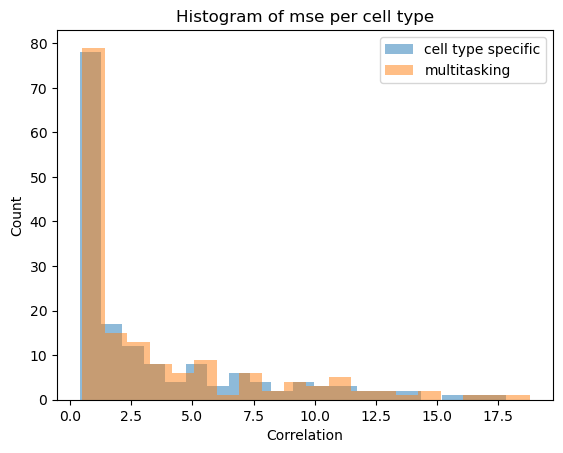

In [28]:
# bins = np.linspace(0.2,1,20)
bins = 20

plt.hist(token_celltype, bins=bins, alpha=0.5, label='cell type specific')
plt.hist(all_celltype, bins=bins, alpha=0.5, label='multitasking')

# Add legend, labels, and title
plt.legend()
plt.xlabel('Correlation')
plt.ylabel('Count')
plt.title('Histogram of mse per cell type')

(-1.0, 30.0)

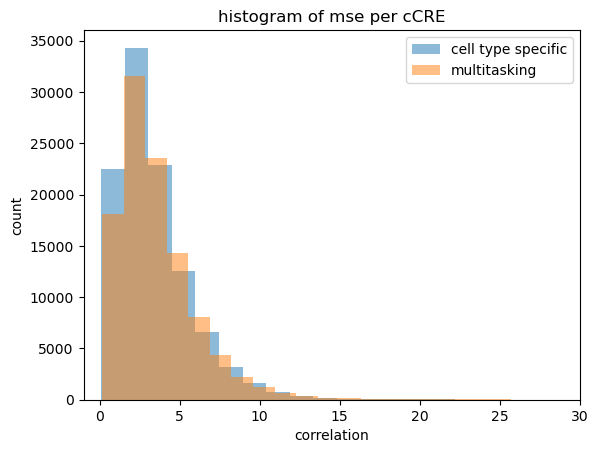

In [32]:
plt.hist(token_ccre, bins = 70, alpha = 0.5, label = 'cell type specific')
plt.hist(all_ccre, bins = 70, alpha = 0.5, label = 'multitasking')
plt.legend()
plt.xlabel('correlation')
plt.ylabel('count')
plt.title('histogram of mse per cCRE')
plt.xlim([-1, 30])

#lots of outliers, seems more lognormal

# statistical tests again

In [1]:
#let's repeat all the tests

#first load in the results
import torch
target_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/targets.pt')
predict_token = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/predicts.pt')

targets_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/targets.pt')
predicts_all = torch.load('/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-12/11-21-32-769024/checkpoints/predicts.pt')

#verify the labels are the same
print(torch.all(target_token == targets_all))
#we can just use on target
t = target_token

#now let's calculate correlations along rows and columns
from scipy.stats import pearsonr
token_celltype = []
all_celltype = []
for i in range(161):
    target = t[:,i]
    predict = predict_token[:,i]
    token_celltype.append(pearsonr(target, predict).statistic)
    target = t[:,i]
    predict = predicts_all[:,i]
    all_celltype.append(pearsonr(target, predict).statistic)

token_ccre = []
all_ccre = []
for i in range(t.shape[0]):
    target = t[i,:]
    predict = predict_token[i,:]
    token_ccre.append(pearsonr(target, predict).statistic)
    target = t[i,:]
    predict = predicts_all[i,:]
    all_ccre.append(pearsonr(target, predict).statistic)
    
#an dlen of lists
print(len(token_celltype), len(all_celltype), len(token_ccre), len(all_ccre))

tensor(True)


161 161 105252 105252


In [2]:
#now let's do a wilcoxon test
from scipy.stats import wilcoxon
# now do a one sided t test
p = wilcoxon(token_ccre, all_ccre, alternative = 'greater')

WilcoxonResult(statistic=3887382482.0, pvalue=0.0)

# testing if lm head is used

In [1]:
import torch 

import argparse
import os
import sys
import yaml 
from tqdm import tqdm
import json 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.dataloaders.datasets.DNase_dataset import DNaseDataset
from src.tasks.decoders import SequenceDecoder
import pytorch_lightning as pl


# sys.path.append(os.environ.get("SAFARI_PATH", "."))

# from src.models.sequence.long_conv_lm import ConvLMHeadModel
from src.models.sequence.dna_embedding import DNAEmbeddingModel
# from transformers import AutoTokenizer, GPT2LMHeadModel
# from spacy.lang.en.stop_words import STOP_WORDS
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
import torch.nn.functional as F

# d_output = 161

tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
ccre = DNaseDataset(max_length = 1024, split = 'test', tokenizer=tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)

train_cfg = cfg['train']  # grab section `train` section of config
model_cfg = cfg['model_config']  # grab the `model` section of config

d_output = train_cfg['d_output'] 

backbone = DNAEmbeddingModel(**model_cfg)

decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')

ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt'
state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
# loads model from ddp by removing prexix to single if necessary
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
    state_dict["state_dict"], "model."
)

model_state_dict = state_dict["state_dict"]

# need to remove torchmetrics. to remove keys, need to convert to list first
for key in list(model_state_dict.keys()):
    if "torchmetrics" in key:
        model_state_dict.pop(key)

# the state_dict keys slightly mismatch from Lightning..., so we fix it here
decoder_state_dict = {}
decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

#now adjust the backbone
embedding = torch.nn.Embedding(20, 128)
backbone.backbone.embeddings.word_embeddings = embedding #again a hack

# now actually load the state dict to the decoder and backbone separately
decoder.load_state_dict(decoder_state_dict, strict=True)
backbone.load_state_dict(model_state_dict, strict=True)

print(backbone)
print(decoder)


DNAEmbeddingModel(
  (backbone): LMBackbone(
    (embeddings): GPT2Embeddings(
      (word_embeddings): Embedding(20, 128)
    )
    (layers): ModuleList(
      (0): Block(
        (mixer): HyenaOperator(
          (activation): Identity()
          (dropout): Dropout(p=0.0, inplace=False)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (in_proj): Linear(in_features=128, out_features=384, bias=True)
          (short_filter): Conv1d(384, 384, kernel_size=(3,), stride=(1,), padding=(2,), groups=384)
          (filter_fn): HyenaFilter(
            (dropout): Dropout(p=0.0, inplace=False)
            (pos_emb): PositionalEmbedding()
            (implicit_filter): Sequential(
              (0): Linear(in_features=5, out_features=64, bias=True)
              (1): Sin()
              (2): Linear(in_features=64, out_features=64, bias=True)
              (3): Sin()
              (4): Linear(in_features=64, out_features=64, bias=True)
              (5): Sin()

In [4]:
from torch.utils.data import DataLoader


targets_flat = torch.zeros(len(ccre)) #because output is just a single value, it's so obvious it's kind of stupid
predicts_flat = torch.zeros(len(ccre))
DNase = DataLoader(ccre, batch_size=128, shuffle=False, num_workers=4) #results are identical even if you shuffle, obviously since it's just the mean
with torch.no_grad():
    idx = 0
    for i, batch in tqdm(enumerate(DNase), total = len(DNase)):
        seq, target = batch
        # seq = seq.to(device)
        b_size = seq.shape[0]
        # target = target.to(device)
        y_hat_backbone, _ = backbone(seq)
        y_hat = decoder(y_hat_backbone)
        break

  0%|                                                                                                                                                                                                       | 0/132388 [00:03<?, ?it/s]


In [5]:
print(y_hat_backbone.shape) #batch size by input by 128, makes sense, that's the dimension of the embedding
#but then we have the word embeddings... how is this sued
#lm head is not used for downstream tasks, only actual lnaguage modeling!! This is great!!

torch.Size([128, 1023, 128])
